In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


In [2]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [3]:
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [4]:
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder


In [5]:
#preprocess.
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [6]:
#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical


In [7]:
# specifically for cnn
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [8]:
import tensorflow as tf
import random as rn

In [9]:
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np         
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm 

In [10]:
TRAIN_DIR = '../data/train'
TEST_DIR = '../data/test'
IMG_SIZE=100

In [11]:
def label_img(img):
    word_label = img.split('.')[0]
    return word_label

In [12]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),str(label)])
        
    shuffle(training_data)
    return training_data

In [13]:
train_data=create_train_data()
train_data=np.array(train_data)
print(train_data.shape)
X= np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y= np.array([i[1] for i in train_data])

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:43<00:00, 580.70it/s]


(25000, 2)


In [14]:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img)])
        
    shuffle(testing_data)
    return testing_data

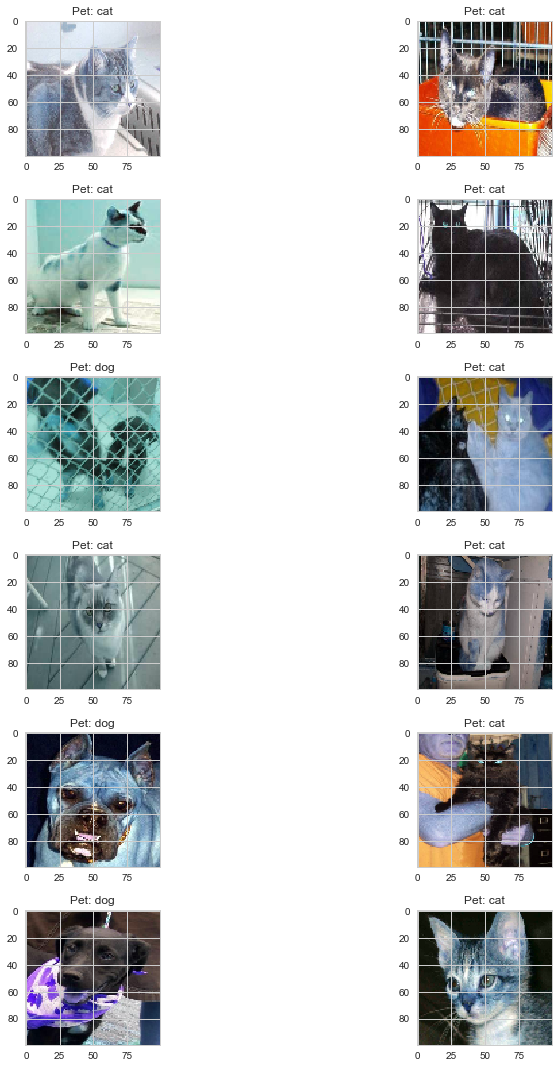

In [15]:
fig,ax=plt.subplots(6,2)
fig.set_size_inches(15,15)
for i in range(6):
    for j in range (2):
        l=rn.randint(0,len(Y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Pet: '+Y[l])
        
plt.tight_layout()

In [16]:
le=LabelEncoder()
Z=Y
Y=le.fit_transform(Y)
Y=to_categorical(Y)

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [18]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [19]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(2, activation = "sigmoid"))
 

In [20]:
batch_size=128
epochs=20

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.1)

In [21]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    horizontal_flip=True)
datagen.fit(x_train)

In [22]:
model.compile(optimizer=RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 96)        55392     
__________

In [24]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,callbacks=[red_lr])

Epoch 1/20
156/156 [==============================] - ETA: 13:46 - loss: 0.6930 - acc: 0.54 - ETA: 12:39 - loss: 2.1718 - acc: 0.49 - ETA: 12:15 - loss: 1.6790 - acc: 0.49 - ETA: 12:04 - loss: 1.4319 - acc: 0.51 - ETA: 11:54 - loss: 1.2915 - acc: 0.50 - ETA: 11:47 - loss: 1.1915 - acc: 0.50 - ETA: 11:38 - loss: 1.1204 - acc: 0.50 - ETA: 11:34 - loss: 1.0673 - acc: 0.49 - ETA: 11:30 - loss: 1.0259 - acc: 0.49 - ETA: 11:24 - loss: 0.9926 - acc: 0.49 - ETA: 11:17 - loss: 0.9654 - acc: 0.49 - ETA: 11:12 - loss: 0.9426 - acc: 0.50 - ETA: 11:05 - loss: 0.9234 - acc: 0.50 - ETA: 10:59 - loss: 0.9070 - acc: 0.50 - ETA: 10:53 - loss: 0.8928 - acc: 0.50 - ETA: 10:47 - loss: 0.8803 - acc: 0.49 - ETA: 10:42 - loss: 0.8693 - acc: 0.50 - ETA: 10:36 - loss: 0.8596 - acc: 0.49 - ETA: 10:31 - loss: 0.8509 - acc: 0.49 - ETA: 10:26 - loss: 0.8429 - acc: 0.50 - ETA: 10:21 - loss: 0.8359 - acc: 0.49 - ETA: 10:16 - loss: 0.8294 - acc: 0.49 - ETA: 10:11 - loss: 0.8236 - acc: 0.49 - ETA: 10:07 - loss: 0.8181 

156/156 [==============================] - ETA: 3:06 - loss: 0.6915 - acc: 0.515 - ETA: 7:23 - loss: 0.6896 - acc: 0.511 - ETA: 8:46 - loss: 0.6868 - acc: 0.529 - ETA: 9:25 - loss: 0.6853 - acc: 0.546 - ETA: 9:46 - loss: 0.6791 - acc: 0.548 - ETA: 9:59 - loss: 0.6752 - acc: 0.552 - ETA: 10:07 - loss: 0.6761 - acc: 0.54 - ETA: 10:15 - loss: 0.6755 - acc: 0.55 - ETA: 10:21 - loss: 0.6802 - acc: 0.55 - ETA: 10:25 - loss: 0.6805 - acc: 0.55 - ETA: 10:26 - loss: 0.6800 - acc: 0.56 - ETA: 10:27 - loss: 0.6823 - acc: 0.55 - ETA: 10:27 - loss: 0.6847 - acc: 0.55 - ETA: 10:25 - loss: 0.6846 - acc: 0.55 - ETA: 10:24 - loss: 0.6842 - acc: 0.55 - ETA: 10:21 - loss: 0.6846 - acc: 0.55 - ETA: 10:19 - loss: 0.6844 - acc: 0.55 - ETA: 10:17 - loss: 0.6851 - acc: 0.55 - ETA: 10:13 - loss: 0.6849 - acc: 0.55 - ETA: 10:09 - loss: 0.6854 - acc: 0.55 - ETA: 10:05 - loss: 0.6850 - acc: 0.55 - ETA: 10:01 - loss: 0.6843 - acc: 0.55 - ETA: 9:58 - loss: 0.6837 - acc: 0.5572 - ETA: 9:54 - loss: 0.6834 - acc: 0.55

156/156 [==============================] - ETA: 11:30 - loss: 0.6716 - acc: 0.57 - ETA: 7:13 - loss: 0.6647 - acc: 0.6094 - ETA: 8:35 - loss: 0.6706 - acc: 0.595 - ETA: 9:12 - loss: 0.6678 - acc: 0.593 - ETA: 9:34 - loss: 0.6705 - acc: 0.584 - ETA: 9:47 - loss: 0.6677 - acc: 0.581 - ETA: 9:58 - loss: 0.6641 - acc: 0.592 - ETA: 10:01 - loss: 0.6618 - acc: 0.59 - ETA: 10:05 - loss: 0.6618 - acc: 0.59 - ETA: 10:06 - loss: 0.6597 - acc: 0.60 - ETA: 10:07 - loss: 0.6599 - acc: 0.59 - ETA: 10:07 - loss: 0.6601 - acc: 0.60 - ETA: 10:06 - loss: 0.6581 - acc: 0.60 - ETA: 10:05 - loss: 0.6588 - acc: 0.60 - ETA: 10:05 - loss: 0.6566 - acc: 0.60 - ETA: 10:04 - loss: 0.6577 - acc: 0.60 - ETA: 10:01 - loss: 0.6586 - acc: 0.60 - ETA: 9:59 - loss: 0.6571 - acc: 0.6107 - ETA: 9:57 - loss: 0.6555 - acc: 0.614 - ETA: 9:54 - loss: 0.6544 - acc: 0.614 - ETA: 9:51 - loss: 0.6523 - acc: 0.615 - ETA: 9:47 - loss: 0.6526 - acc: 0.615 - ETA: 9:43 - loss: 0.6585 - acc: 0.610 - ETA: 9:40 - loss: 0.6584 - acc: 0.6

156/156 [==============================] - ETA: 11:41 - loss: 0.6252 - acc: 0.68 - ETA: 11:30 - loss: 0.6239 - acc: 0.66 - ETA: 8:35 - loss: 0.6228 - acc: 0.6497 - ETA: 9:13 - loss: 0.6230 - acc: 0.656 - ETA: 9:34 - loss: 0.6626 - acc: 0.644 - ETA: 9:47 - loss: 0.6652 - acc: 0.633 - ETA: 10:02 - loss: 0.6630 - acc: 0.63 - ETA: 10:09 - loss: 0.6606 - acc: 0.63 - ETA: 10:11 - loss: 0.6600 - acc: 0.62 - ETA: 10:11 - loss: 0.6577 - acc: 0.62 - ETA: 10:11 - loss: 0.6578 - acc: 0.63 - ETA: 10:10 - loss: 0.6582 - acc: 0.63 - ETA: 10:09 - loss: 0.6544 - acc: 0.64 - ETA: 10:06 - loss: 0.7025 - acc: 0.63 - ETA: 10:04 - loss: 0.7368 - acc: 0.62 - ETA: 10:02 - loss: 0.7342 - acc: 0.61 - ETA: 10:00 - loss: 0.7312 - acc: 0.61 - ETA: 9:58 - loss: 0.7262 - acc: 0.6168 - ETA: 9:57 - loss: 0.7212 - acc: 0.617 - ETA: 9:54 - loss: 0.7179 - acc: 0.619 - ETA: 9:50 - loss: 0.7131 - acc: 0.622 - ETA: 9:46 - loss: 0.7108 - acc: 0.620 - ETA: 9:42 - loss: 0.7072 - acc: 0.621 - ETA: 9:38 - loss: 0.7049 - acc: 0.6

156/156 [==============================] - ETA: 12:12 - loss: 0.6117 - acc: 0.65 - ETA: 11:57 - loss: 0.6111 - acc: 0.65 - ETA: 11:47 - loss: 0.6012 - acc: 0.67 - ETA: 9:32 - loss: 0.6452 - acc: 0.6602 - ETA: 9:52 - loss: 0.6489 - acc: 0.636 - ETA: 10:10 - loss: 0.6425 - acc: 0.65 - ETA: 10:17 - loss: 0.6373 - acc: 0.65 - ETA: 10:26 - loss: 0.6310 - acc: 0.66 - ETA: 10:30 - loss: 0.6259 - acc: 0.66 - ETA: 10:30 - loss: 0.6248 - acc: 0.66 - ETA: 10:29 - loss: 0.6204 - acc: 0.66 - ETA: 10:27 - loss: 0.6174 - acc: 0.66 - ETA: 10:24 - loss: 0.6193 - acc: 0.66 - ETA: 10:22 - loss: 0.6185 - acc: 0.66 - ETA: 10:20 - loss: 0.6212 - acc: 0.66 - ETA: 10:17 - loss: 0.6225 - acc: 0.66 - ETA: 10:13 - loss: 0.6171 - acc: 0.66 - ETA: 10:10 - loss: 0.6184 - acc: 0.67 - ETA: 10:07 - loss: 0.6190 - acc: 0.66 - ETA: 10:03 - loss: 0.6199 - acc: 0.66 - ETA: 9:59 - loss: 0.6179 - acc: 0.6682 - ETA: 9:55 - loss: 0.6152 - acc: 0.669 - ETA: 9:51 - loss: 0.6155 - acc: 0.669 - ETA: 9:46 - loss: 0.6156 - acc: 0.6

156/156 [==============================] - ETA: 11:45 - loss: 0.4927 - acc: 0.72 - ETA: 11:38 - loss: 0.5489 - acc: 0.72 - ETA: 11:33 - loss: 0.5654 - acc: 0.71 - ETA: 11:29 - loss: 0.5633 - acc: 0.72 - ETA: 9:43 - loss: 0.5514 - acc: 0.7344 - ETA: 9:56 - loss: 0.5414 - acc: 0.739 - ETA: 10:04 - loss: 0.7250 - acc: 0.70 - ETA: 10:08 - loss: 0.7291 - acc: 0.68 - ETA: 10:10 - loss: 0.7249 - acc: 0.67 - ETA: 10:12 - loss: 0.7132 - acc: 0.67 - ETA: 10:13 - loss: 0.6993 - acc: 0.68 - ETA: 10:13 - loss: 0.6941 - acc: 0.67 - ETA: 10:12 - loss: 0.6895 - acc: 0.67 - ETA: 10:11 - loss: 0.6799 - acc: 0.68 - ETA: 10:11 - loss: 0.6711 - acc: 0.68 - ETA: 10:09 - loss: 0.6610 - acc: 0.69 - ETA: 10:08 - loss: 0.6567 - acc: 0.69 - ETA: 10:06 - loss: 0.6511 - acc: 0.69 - ETA: 10:06 - loss: 0.6464 - acc: 0.69 - ETA: 10:05 - loss: 0.6437 - acc: 0.69 - ETA: 10:03 - loss: 0.6471 - acc: 0.69 - ETA: 10:01 - loss: 0.6452 - acc: 0.69 - ETA: 9:58 - loss: 0.6428 - acc: 0.6904 - ETA: 9:55 - loss: 0.6404 - acc: 0.6

156/156 [==============================] - ETA: 11:47 - loss: 0.5382 - acc: 0.73 - ETA: 11:52 - loss: 0.5264 - acc: 0.73 - ETA: 11:49 - loss: 0.5276 - acc: 0.73 - ETA: 11:48 - loss: 0.5277 - acc: 0.74 - ETA: 11:41 - loss: 0.5479 - acc: 0.73 - ETA: 10:09 - loss: 0.5662 - acc: 0.71 - ETA: 10:16 - loss: 0.5661 - acc: 0.72 - ETA: 10:20 - loss: 0.5559 - acc: 0.72 - ETA: 10:22 - loss: 0.5440 - acc: 0.73 - ETA: 10:22 - loss: 0.5570 - acc: 0.72 - ETA: 10:22 - loss: 0.7343 - acc: 0.71 - ETA: 10:20 - loss: 0.7220 - acc: 0.70 - ETA: 10:19 - loss: 0.7059 - acc: 0.71 - ETA: 10:17 - loss: 0.6963 - acc: 0.71 - ETA: 10:14 - loss: 0.6878 - acc: 0.70 - ETA: 10:12 - loss: 0.6796 - acc: 0.70 - ETA: 10:09 - loss: 0.6748 - acc: 0.70 - ETA: 10:05 - loss: 0.6624 - acc: 0.71 - ETA: 10:02 - loss: 0.6553 - acc: 0.71 - ETA: 9:59 - loss: 0.6483 - acc: 0.7139 - ETA: 9:55 - loss: 0.6431 - acc: 0.714 - ETA: 9:52 - loss: 0.6409 - acc: 0.714 - ETA: 9:48 - loss: 0.6362 - acc: 0.712 - ETA: 9:45 - loss: 0.6339 - acc: 0.71

156/156 [==============================] - ETA: 11:46 - loss: 0.5797 - acc: 0.69 - ETA: 11:40 - loss: 0.5959 - acc: 0.67 - ETA: 11:34 - loss: 0.6003 - acc: 0.66 - ETA: 11:29 - loss: 0.5874 - acc: 0.66 - ETA: 11:25 - loss: 0.5823 - acc: 0.67 - ETA: 11:20 - loss: 0.5776 - acc: 0.69 - ETA: 10:04 - loss: 0.5780 - acc: 0.68 - ETA: 10:08 - loss: 0.5676 - acc: 0.69 - ETA: 10:10 - loss: 0.5609 - acc: 0.70 - ETA: 10:11 - loss: 0.5580 - acc: 0.70 - ETA: 10:12 - loss: 0.5537 - acc: 0.71 - ETA: 10:12 - loss: 0.5481 - acc: 0.71 - ETA: 10:10 - loss: 0.5465 - acc: 0.71 - ETA: 10:08 - loss: 0.5423 - acc: 0.72 - ETA: 10:06 - loss: 0.5399 - acc: 0.72 - ETA: 10:04 - loss: 0.5396 - acc: 0.72 - ETA: 10:01 - loss: 0.5388 - acc: 0.72 - ETA: 9:58 - loss: 0.5365 - acc: 0.7303 - ETA: 9:56 - loss: 0.5371 - acc: 0.731 - ETA: 9:52 - loss: 0.5351 - acc: 0.733 - ETA: 9:49 - loss: 0.5334 - acc: 0.735 - ETA: 9:46 - loss: 0.5316 - acc: 0.737 - ETA: 9:42 - loss: 0.5287 - acc: 0.739 - ETA: 9:39 - loss: 0.5262 - acc: 0.74

156/156 [==============================] - ETA: 11:42 - loss: 0.5768 - acc: 0.71 - ETA: 11:39 - loss: 0.5096 - acc: 0.75 - ETA: 11:34 - loss: 0.4727 - acc: 0.78 - ETA: 11:30 - loss: 0.4655 - acc: 0.79 - ETA: 11:25 - loss: 0.4558 - acc: 0.78 - ETA: 11:21 - loss: 0.4470 - acc: 0.79 - ETA: 11:17 - loss: 0.4464 - acc: 0.79 - ETA: 10:10 - loss: 0.4508 - acc: 0.79 - ETA: 10:14 - loss: 0.4428 - acc: 0.79 - ETA: 10:15 - loss: 0.4394 - acc: 0.79 - ETA: 10:15 - loss: 0.4404 - acc: 0.79 - ETA: 10:15 - loss: 0.4448 - acc: 0.79 - ETA: 10:14 - loss: 0.4414 - acc: 0.79 - ETA: 10:13 - loss: 0.4411 - acc: 0.79 - ETA: 10:10 - loss: 0.4380 - acc: 0.79 - ETA: 10:08 - loss: 0.4404 - acc: 0.79 - ETA: 10:06 - loss: 0.4398 - acc: 0.79 - ETA: 10:03 - loss: 0.4398 - acc: 0.79 - ETA: 10:00 - loss: 0.4366 - acc: 0.79 - ETA: 9:57 - loss: 0.4350 - acc: 0.8006 - ETA: 9:53 - loss: 0.4299 - acc: 0.802 - ETA: 9:50 - loss: 0.4345 - acc: 0.799 - ETA: 9:46 - loss: 0.4344 - acc: 0.797 - ETA: 9:43 - loss: 0.4350 - acc: 0.79

156/156 [==============================] - ETA: 11:27 - loss: 0.4244 - acc: 0.78 - ETA: 11:21 - loss: 0.4524 - acc: 0.76 - ETA: 11:20 - loss: 0.4527 - acc: 0.76 - ETA: 11:20 - loss: 0.4536 - acc: 0.77 - ETA: 11:14 - loss: 0.4496 - acc: 0.77 - ETA: 11:10 - loss: 0.4360 - acc: 0.78 - ETA: 11:04 - loss: 0.4330 - acc: 0.78 - ETA: 11:00 - loss: 0.4256 - acc: 0.79 - ETA: 10:02 - loss: 0.4143 - acc: 0.79 - ETA: 10:03 - loss: 0.4237 - acc: 0.79 - ETA: 10:04 - loss: 0.4284 - acc: 0.79 - ETA: 10:03 - loss: 0.4272 - acc: 0.79 - ETA: 10:02 - loss: 0.4212 - acc: 0.79 - ETA: 10:01 - loss: 0.4215 - acc: 0.79 - ETA: 9:59 - loss: 0.4200 - acc: 0.8013 - ETA: 9:56 - loss: 0.4192 - acc: 0.803 - ETA: 9:53 - loss: 0.4212 - acc: 0.799 - ETA: 9:51 - loss: 0.4183 - acc: 0.801 - ETA: 9:48 - loss: 0.4170 - acc: 0.802 - ETA: 9:45 - loss: 0.4189 - acc: 0.801 - ETA: 9:41 - loss: 0.4174 - acc: 0.803 - ETA: 9:38 - loss: 0.4183 - acc: 0.802 - ETA: 9:34 - loss: 0.4201 - acc: 0.802 - ETA: 9:31 - loss: 0.4200 - acc: 0.80

156/156 [==============================] - ETA: 11:43 - loss: 0.3990 - acc: 0.80 - ETA: 11:33 - loss: 0.4231 - acc: 0.81 - ETA: 11:32 - loss: 0.4312 - acc: 0.81 - ETA: 11:30 - loss: 0.4164 - acc: 0.82 - ETA: 11:23 - loss: 0.4272 - acc: 0.81 - ETA: 11:17 - loss: 0.4180 - acc: 0.81 - ETA: 11:11 - loss: 0.4088 - acc: 0.82 - ETA: 11:06 - loss: 0.4017 - acc: 0.82 - ETA: 11:01 - loss: 0.3958 - acc: 0.82 - ETA: 10:08 - loss: 0.4017 - acc: 0.82 - ETA: 10:08 - loss: 0.4120 - acc: 0.81 - ETA: 10:07 - loss: 0.4083 - acc: 0.81 - ETA: 10:05 - loss: 0.4101 - acc: 0.81 - ETA: 10:03 - loss: 0.4126 - acc: 0.81 - ETA: 10:01 - loss: 0.4118 - acc: 0.81 - ETA: 9:58 - loss: 0.4104 - acc: 0.8167 - ETA: 9:55 - loss: 0.4107 - acc: 0.814 - ETA: 9:52 - loss: 0.4125 - acc: 0.811 - ETA: 9:49 - loss: 0.4145 - acc: 0.810 - ETA: 9:46 - loss: 0.4154 - acc: 0.810 - ETA: 9:43 - loss: 0.4204 - acc: 0.807 - ETA: 9:39 - loss: 0.4200 - acc: 0.807 - ETA: 9:36 - loss: 0.4212 - acc: 0.806 - ETA: 9:32 - loss: 0.4212 - acc: 0.80

156/156 [==============================] - ETA: 11:32 - loss: 0.3747 - acc: 0.81 - ETA: 11:27 - loss: 0.3848 - acc: 0.83 - ETA: 11:22 - loss: 0.4048 - acc: 0.82 - ETA: 11:17 - loss: 0.3936 - acc: 0.83 - ETA: 11:12 - loss: 0.4141 - acc: 0.82 - ETA: 11:08 - loss: 0.4308 - acc: 0.81 - ETA: 11:04 - loss: 0.4183 - acc: 0.82 - ETA: 11:01 - loss: 0.4144 - acc: 0.82 - ETA: 10:57 - loss: 0.4218 - acc: 0.81 - ETA: 10:53 - loss: 0.4207 - acc: 0.81 - ETA: 10:06 - loss: 0.4344 - acc: 0.80 - ETA: 10:06 - loss: 0.4266 - acc: 0.81 - ETA: 10:05 - loss: 0.4237 - acc: 0.81 - ETA: 10:04 - loss: 0.4296 - acc: 0.81 - ETA: 10:02 - loss: 0.4226 - acc: 0.81 - ETA: 9:59 - loss: 0.4211 - acc: 0.8169 - ETA: 9:57 - loss: 0.4167 - acc: 0.817 - ETA: 9:54 - loss: 0.4157 - acc: 0.816 - ETA: 9:51 - loss: 0.4115 - acc: 0.818 - ETA: 9:48 - loss: 0.4125 - acc: 0.817 - ETA: 9:44 - loss: 0.4117 - acc: 0.817 - ETA: 9:41 - loss: 0.4117 - acc: 0.816 - ETA: 9:37 - loss: 0.4087 - acc: 0.817 - ETA: 9:33 - loss: 0.4068 - acc: 0.81

156/156 [==============================] - ETA: 11:34 - loss: 0.3762 - acc: 0.83 - ETA: 11:28 - loss: 0.3494 - acc: 0.83 - ETA: 11:22 - loss: 0.3888 - acc: 0.81 - ETA: 11:19 - loss: 0.3869 - acc: 0.82 - ETA: 11:14 - loss: 0.3771 - acc: 0.83 - ETA: 11:09 - loss: 0.3800 - acc: 0.82 - ETA: 11:03 - loss: 0.3809 - acc: 0.82 - ETA: 10:59 - loss: 0.3847 - acc: 0.82 - ETA: 10:56 - loss: 0.3927 - acc: 0.81 - ETA: 10:51 - loss: 0.3928 - acc: 0.81 - ETA: 10:47 - loss: 0.3942 - acc: 0.81 - ETA: 10:02 - loss: 0.3954 - acc: 0.82 - ETA: 10:02 - loss: 0.3976 - acc: 0.81 - ETA: 10:00 - loss: 0.3944 - acc: 0.82 - ETA: 9:58 - loss: 0.3967 - acc: 0.8190 - ETA: 9:56 - loss: 0.3978 - acc: 0.817 - ETA: 9:54 - loss: 0.3959 - acc: 0.818 - ETA: 9:51 - loss: 0.3950 - acc: 0.818 - ETA: 9:48 - loss: 0.3910 - acc: 0.819 - ETA: 9:45 - loss: 0.3941 - acc: 0.818 - ETA: 9:42 - loss: 0.3934 - acc: 0.817 - ETA: 9:39 - loss: 0.3917 - acc: 0.818 - ETA: 9:35 - loss: 0.3921 - acc: 0.818 - ETA: 9:32 - loss: 0.3933 - acc: 0.81

156/156 [==============================] - ETA: 11:35 - loss: 0.4475 - acc: 0.77 - ETA: 11:26 - loss: 0.4271 - acc: 0.80 - ETA: 11:23 - loss: 0.4066 - acc: 0.80 - ETA: 11:18 - loss: 0.4090 - acc: 0.80 - ETA: 11:14 - loss: 0.4080 - acc: 0.79 - ETA: 11:10 - loss: 0.4140 - acc: 0.80 - ETA: 11:05 - loss: 0.4036 - acc: 0.80 - ETA: 11:01 - loss: 0.3987 - acc: 0.81 - ETA: 10:55 - loss: 0.3955 - acc: 0.81 - ETA: 10:51 - loss: 0.3959 - acc: 0.81 - ETA: 10:47 - loss: 0.3900 - acc: 0.81 - ETA: 10:42 - loss: 0.3865 - acc: 0.82 - ETA: 10:02 - loss: 0.3927 - acc: 0.81 - ETA: 10:00 - loss: 0.3874 - acc: 0.81 - ETA: 9:58 - loss: 0.3788 - acc: 0.8255 - ETA: 9:56 - loss: 0.3764 - acc: 0.825 - ETA: 9:53 - loss: 0.3768 - acc: 0.824 - ETA: 9:50 - loss: 0.3757 - acc: 0.825 - ETA: 9:47 - loss: 0.3779 - acc: 0.823 - ETA: 9:44 - loss: 0.3780 - acc: 0.824 - ETA: 9:41 - loss: 0.3802 - acc: 0.823 - ETA: 9:38 - loss: 0.3807 - acc: 0.823 - ETA: 9:34 - loss: 0.3814 - acc: 0.823 - ETA: 9:31 - loss: 0.3814 - acc: 0.82

156/156 [==============================] - ETA: 11:32 - loss: 0.3536 - acc: 0.84 - ETA: 11:27 - loss: 0.3269 - acc: 0.86 - ETA: 11:21 - loss: 0.3297 - acc: 0.87 - ETA: 11:19 - loss: 0.3602 - acc: 0.85 - ETA: 11:14 - loss: 0.3672 - acc: 0.84 - ETA: 11:09 - loss: 0.3699 - acc: 0.84 - ETA: 11:05 - loss: 0.3652 - acc: 0.84 - ETA: 11:01 - loss: 0.3625 - acc: 0.84 - ETA: 10:56 - loss: 0.3683 - acc: 0.84 - ETA: 10:52 - loss: 0.3643 - acc: 0.84 - ETA: 10:47 - loss: 0.3708 - acc: 0.84 - ETA: 10:43 - loss: 0.3740 - acc: 0.83 - ETA: 10:39 - loss: 0.3717 - acc: 0.84 - ETA: 10:01 - loss: 0.3672 - acc: 0.84 - ETA: 9:59 - loss: 0.3647 - acc: 0.8469 - ETA: 9:56 - loss: 0.3647 - acc: 0.845 - ETA: 9:54 - loss: 0.3670 - acc: 0.844 - ETA: 9:51 - loss: 0.3643 - acc: 0.846 - ETA: 9:48 - loss: 0.3642 - acc: 0.845 - ETA: 9:45 - loss: 0.3635 - acc: 0.843 - ETA: 9:41 - loss: 0.3624 - acc: 0.845 - ETA: 9:38 - loss: 0.3633 - acc: 0.845 - ETA: 9:34 - loss: 0.3657 - acc: 0.843 - ETA: 9:31 - loss: 0.3684 - acc: 0.84

156/156 [==============================] - ETA: 11:32 - loss: 0.3565 - acc: 0.79 - ETA: 11:25 - loss: 0.3989 - acc: 0.78 - ETA: 11:23 - loss: 0.4140 - acc: 0.77 - ETA: 11:17 - loss: 0.4047 - acc: 0.78 - ETA: 11:13 - loss: 0.4277 - acc: 0.78 - ETA: 11:08 - loss: 0.4207 - acc: 0.79 - ETA: 11:05 - loss: 0.4298 - acc: 0.79 - ETA: 10:59 - loss: 0.4212 - acc: 0.79 - ETA: 10:54 - loss: 0.4203 - acc: 0.79 - ETA: 10:50 - loss: 0.4091 - acc: 0.80 - ETA: 10:46 - loss: 0.4093 - acc: 0.80 - ETA: 10:41 - loss: 0.4052 - acc: 0.80 - ETA: 10:37 - loss: 0.4022 - acc: 0.80 - ETA: 10:33 - loss: 0.3969 - acc: 0.80 - ETA: 9:57 - loss: 0.3817 - acc: 0.8169 - ETA: 9:55 - loss: 0.3778 - acc: 0.821 - ETA: 9:53 - loss: 0.3785 - acc: 0.822 - ETA: 9:50 - loss: 0.3782 - acc: 0.822 - ETA: 9:47 - loss: 0.3732 - acc: 0.826 - ETA: 9:44 - loss: 0.3754 - acc: 0.826 - ETA: 9:41 - loss: 0.3741 - acc: 0.827 - ETA: 9:38 - loss: 0.3790 - acc: 0.824 - ETA: 9:34 - loss: 0.3800 - acc: 0.825 - ETA: 9:31 - loss: 0.3784 - acc: 0.82

156/156 [==============================] - ETA: 11:33 - loss: 0.3212 - acc: 0.86 - ETA: 11:31 - loss: 0.3700 - acc: 0.84 - ETA: 11:24 - loss: 0.3952 - acc: 0.81 - ETA: 11:18 - loss: 0.3916 - acc: 0.82 - ETA: 11:14 - loss: 0.4061 - acc: 0.81 - ETA: 11:08 - loss: 0.4012 - acc: 0.81 - ETA: 11:04 - loss: 0.3954 - acc: 0.82 - ETA: 10:59 - loss: 0.3957 - acc: 0.82 - ETA: 10:56 - loss: 0.3918 - acc: 0.82 - ETA: 10:51 - loss: 0.3855 - acc: 0.82 - ETA: 10:46 - loss: 0.3829 - acc: 0.82 - ETA: 10:42 - loss: 0.3771 - acc: 0.83 - ETA: 10:38 - loss: 0.3749 - acc: 0.83 - ETA: 10:33 - loss: 0.3762 - acc: 0.83 - ETA: 10:29 - loss: 0.3804 - acc: 0.83 - ETA: 9:56 - loss: 0.3730 - acc: 0.8369 - ETA: 9:53 - loss: 0.3721 - acc: 0.838 - ETA: 9:50 - loss: 0.3697 - acc: 0.838 - ETA: 9:47 - loss: 0.3717 - acc: 0.834 - ETA: 9:44 - loss: 0.3745 - acc: 0.834 - ETA: 9:41 - loss: 0.3773 - acc: 0.832 - ETA: 9:37 - loss: 0.3765 - acc: 0.834 - ETA: 9:34 - loss: 0.3776 - acc: 0.833 - ETA: 9:31 - loss: 0.3812 - acc: 0.83

156/156 [==============================] - ETA: 11:37 - loss: 0.3281 - acc: 0.87 - ETA: 11:28 - loss: 0.3226 - acc: 0.86 - ETA: 11:24 - loss: 0.3597 - acc: 0.84 - ETA: 11:20 - loss: 0.3523 - acc: 0.84 - ETA: 11:15 - loss: 0.3467 - acc: 0.84 - ETA: 11:10 - loss: 0.3327 - acc: 0.85 - ETA: 11:06 - loss: 0.3308 - acc: 0.85 - ETA: 11:02 - loss: 0.3329 - acc: 0.85 - ETA: 10:57 - loss: 0.3324 - acc: 0.85 - ETA: 10:52 - loss: 0.3347 - acc: 0.84 - ETA: 10:47 - loss: 0.3369 - acc: 0.84 - ETA: 10:42 - loss: 0.3428 - acc: 0.84 - ETA: 10:38 - loss: 0.3439 - acc: 0.84 - ETA: 10:34 - loss: 0.3468 - acc: 0.83 - ETA: 10:29 - loss: 0.3428 - acc: 0.84 - ETA: 10:24 - loss: 0.3451 - acc: 0.83 - ETA: 9:53 - loss: 0.3362 - acc: 0.8456 - ETA: 9:50 - loss: 0.3388 - acc: 0.845 - ETA: 9:47 - loss: 0.3406 - acc: 0.843 - ETA: 9:44 - loss: 0.3387 - acc: 0.844 - ETA: 9:41 - loss: 0.3413 - acc: 0.841 - ETA: 9:37 - loss: 0.3427 - acc: 0.839 - ETA: 9:34 - loss: 0.3455 - acc: 0.838 - ETA: 9:30 - loss: 0.3443 - acc: 0.83

156/156 [==============================] - ETA: 11:34 - loss: 0.4010 - acc: 0.83 - ETA: 11:29 - loss: 0.4015 - acc: 0.81 - ETA: 11:25 - loss: 0.4431 - acc: 0.78 - ETA: 11:19 - loss: 0.4225 - acc: 0.79 - ETA: 11:15 - loss: 0.4037 - acc: 0.81 - ETA: 11:12 - loss: 0.3865 - acc: 0.82 - ETA: 11:06 - loss: 0.3940 - acc: 0.82 - ETA: 11:02 - loss: 0.3904 - acc: 0.82 - ETA: 10:57 - loss: 0.3802 - acc: 0.82 - ETA: 10:52 - loss: 0.3753 - acc: 0.83 - ETA: 10:48 - loss: 0.3657 - acc: 0.83 - ETA: 10:43 - loss: 0.3650 - acc: 0.83 - ETA: 10:38 - loss: 0.3595 - acc: 0.83 - ETA: 10:34 - loss: 0.3582 - acc: 0.83 - ETA: 10:29 - loss: 0.3582 - acc: 0.83 - ETA: 10:24 - loss: 0.3570 - acc: 0.83 - ETA: 10:20 - loss: 0.3589 - acc: 0.83 - ETA: 9:50 - loss: 0.3542 - acc: 0.8385 - ETA: 9:47 - loss: 0.3585 - acc: 0.837 - ETA: 9:44 - loss: 0.3615 - acc: 0.835 - ETA: 9:41 - loss: 0.3697 - acc: 0.832 - ETA: 9:37 - loss: 0.3703 - acc: 0.831 - ETA: 9:34 - loss: 0.3695 - acc: 0.830 - ETA: 9:30 - loss: 0.3694 - acc: 0.82

156/156 [==============================] - ETA: 11:29 - loss: 0.4251 - acc: 0.80 - ETA: 11:28 - loss: 0.4220 - acc: 0.79 - ETA: 11:22 - loss: 0.4040 - acc: 0.80 - ETA: 11:18 - loss: 0.3970 - acc: 0.80 - ETA: 11:13 - loss: 0.3873 - acc: 0.81 - ETA: 11:08 - loss: 0.3926 - acc: 0.81 - ETA: 11:04 - loss: 0.4107 - acc: 0.80 - ETA: 10:59 - loss: 0.4124 - acc: 0.80 - ETA: 10:54 - loss: 0.4027 - acc: 0.81 - ETA: 10:50 - loss: 0.4052 - acc: 0.81 - ETA: 10:45 - loss: 0.3978 - acc: 0.81 - ETA: 10:41 - loss: 0.3977 - acc: 0.81 - ETA: 10:37 - loss: 0.3939 - acc: 0.81 - ETA: 10:32 - loss: 0.3903 - acc: 0.81 - ETA: 10:28 - loss: 0.3875 - acc: 0.82 - ETA: 10:24 - loss: 0.3914 - acc: 0.81 - ETA: 10:20 - loss: 0.3873 - acc: 0.82 - ETA: 10:15 - loss: 0.3847 - acc: 0.82 - ETA: 9:47 - loss: 0.3881 - acc: 0.8213 - ETA: 9:44 - loss: 0.3834 - acc: 0.822 - ETA: 9:40 - loss: 0.3804 - acc: 0.825 - ETA: 9:37 - loss: 0.3779 - acc: 0.827 - ETA: 9:34 - loss: 0.3790 - acc: 0.827 - ETA: 9:30 - loss: 0.3784 - acc: 0.82

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()